## Final Project subsetting data

In [1126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress
import seaborn as sns

### Subsetting the data
We have four categories, diagnosed with asthma at age 7 but not age 10, at age 10 but not age 7, at neither age 7 or 10, or at both age 7 and 10. However, all of these categories have different numbers of people, so we took a random sample so that each group has the same number of people.

In [1127]:
#import raw data
asthma = pd.read_csv('URECA_Asthma.csv')
samples = pd.read_csv('NEC_Gene_Exp_All_Samples.txt', sep='\t')

In [1128]:
#find ids for both datasets
ids1 = list(samples.columns[6:])
ids2 = asthma.StudyID.values.tolist()

In [1129]:
#find intersection of ids and filter accordingly
ids = [x for x in ids2 if x in ids1]

asthma = asthma.loc[asthma['StudyID'].apply(lambda x: x in ids)] 
asthma = asthma.drop(columns = ['Unnamed: 0']).reset_index(drop=True)

In [1130]:
#break up asthma dataset into asthma status groups based on age diagnoses
yesyes = asthma.loc[(asthma.asthma_age10 == 'Yes') & (asthma.asthma_age7 == 'Yes')]
yesno = asthma.loc[(asthma.asthma_age10 == 'Yes') & (asthma.asthma_age7 == 'No')]
noyes = asthma.loc[(asthma.asthma_age10 == 'No') & (asthma.asthma_age7 == 'Yes')]
nono = asthma.loc[(asthma.asthma_age10 == 'No') & (asthma.asthma_age7 == 'No')]

In [1131]:
#sample from groups that are too large to match size of smallest group
yy_sample = yesyes.sample(30, random_state=2)
nn_sample = nono.sample(30, random_state=2)
yn_sample = yesno.sample(30, random_state=2)

In [1132]:
#stack, clean, and export
sampled_stats = pd.concat([yy_sample, yn_sample, noyes, nn_sample])
sampled_stats = sampled_stats.reset_index(drop=True)

sampled_stats.to_csv('sampled_stats.csv', index=False)

In [1133]:
#subset genetic data from random sample set 
cols = ['Chr','start','end','pid','gid','strand']
sampled_genes = samples[[i for i in samples.columns if i in sampled_stats['StudyID'].values or i in cols]]

sampled_genes.to_csv('sampled_genes.csv', index=False)

### Data Exploration

The following section is truly me simply messing around with the data, trying to see patterns that are useful for checking dimensionality reduction. It is not necessarily coherent or with an obvious flow. Please no judge.

In [1134]:
sampled_genes

,Chr,start,end,pid,gid,strand,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
0,chr1,33306766,33306767,A3GALT2,A3GALT2,-1,-1.017234,-0.111401,-2.065918,-2.264743,...,-2.209014,-2.362347,-0.446825,0.062528,-2.523725,-2.393736,-2.645699,1.046400,-2.576835,-1.908991
1,chr1,93992835,93992836,ABCA4,ABCA4,-1,4.165987,3.058524,3.488671,4.110296,...,4.611165,2.161215,4.343252,3.762968,3.851315,4.476629,3.729341,4.381385,2.780717,3.645597
2,chr1,229516582,229516583,ABCB10,ABCB10,-1,5.447652,5.354574,5.511511,5.342587,...,6.204614,4.556517,6.028908,5.517268,5.436277,5.073870,6.132378,6.219964,5.311909,5.329413
3,chr1,94418455,94418456,ABCD3,ABCD3,1,8.306946,8.232895,8.092691,7.818736,...,7.972138,7.268831,8.217326,8.042259,8.099242,8.140567,8.220807,8.185952,7.858836,7.647515
4,chr1,179099327,179099328,ABL2,ABL2,-1,4.537354,4.253172,4.200868,3.757625,...,3.463411,3.520297,4.377603,4.603901,3.542364,4.206177,4.320085,3.419859,4.388950,3.517273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15639,chrY,6910686,6910687,TBL1Y,TBL1Y,1,2.152691,-2.433329,-2.065918,-2.264743,...,4.166025,3.310079,-2.031788,2.464626,-2.523725,-2.393736,2.846154,-2.413031,-2.576835,2.948990
15640,chrY,13703567,13703568,TMSB4Y,TMSB4Y,1,4.139270,-2.433329,-2.065918,-2.264743,...,2.434842,3.129507,-2.031788,1.647490,-2.523725,-2.393736,3.082222,-2.413031,-2.576835,3.973652
15641,chrY,12701231,12701232,USP9Y,USP9Y,1,3.664590,-2.433329,-2.065918,-2.264743,...,5.029391,4.735686,-2.031788,3.913385,-2.523725,-2.393736,4.648922,-2.413031,-2.576835,3.973652
15642,chrY,13248379,13248380,UTY,UTY,-1,5.802945,-2.433329,-2.065918,-0.679781,...,4.449197,4.950536,-2.031788,6.103796,-2.523725,-2.393736,4.838117,-2.413031,-2.576835,5.290681


In [1135]:
just_genes = sampled_genes.drop(columns=cols).T.reset_index()
just_genes.head()

,index,0,1,2,3,4,5,6,7,8,...,15634,15635,15636,15637,15638,15639,15640,15641,15642,15643
0,07-08-095-0,-1.017234,4.165987,5.447652,8.306946,4.537354,6.580197,5.211584,7.321131,6.052439,...,6.585155,6.433977,5.425709,4.929185,6.721984,2.152691,4.139270,3.664590,5.802945,4.316666
1,07-08-120-8,-0.111401,3.058524,5.354574,8.232895,4.253172,6.662068,5.701098,7.205107,5.790673,...,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329
2,07-08-122-0,-2.065918,3.488671,5.511511,8.092691,4.200868,6.658596,4.899866,7.249231,6.260511,...,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918
3,07-08-123-1,-2.264743,4.110296,5.342587,7.818736,3.757625,7.050406,5.169885,7.514976,5.920132,...,-0.679781,-2.264743,-0.679781,-2.264743,-0.679781,-2.264743,-2.264743,-2.264743,-0.679781,-2.264743
4,07-08-015-6,-0.535400,5.530689,5.993380,8.007632,4.254677,6.422670,5.667540,6.871160,5.155762,...,7.086652,6.187977,5.862631,3.371491,7.125190,3.660997,3.607558,3.305902,5.347243,4.146424


In [1136]:
sampled_stats.head()

,StudyID,Sex,asthma_age10,asthma_age7
0,07-07-020-6,Male,Yes,Yes
1,07-02-092-3,Female,Yes,Yes
2,07-08-028-2,Male,Yes,Yes
3,07-08-106-4,Male,Yes,Yes
4,07-02-076-7,Male,Yes,Yes


In [1137]:
#Code from Monica Gould

sampled_stats["asthma_group"] = None
for index, row in sampled_stats.iterrows():
    if row.asthma_age10 == "Yes" and row.asthma_age7 == "Yes":
        sampled_stats.loc[index, "asthma_group"] = 1
    if row.asthma_age10 == "No" and row.asthma_age7 == "No":
        sampled_stats.loc[index, "asthma_group"] = 2
    if row.asthma_age10 == "No" and row.asthma_age7 == "Yes":
        sampled_stats.loc[index, "asthma_group"] = 3
    if row.asthma_age10 == "Yes" and row.asthma_age7 == "No":
        sampled_stats.loc[index, "asthma_group"] = 4
        
sampled_stats.head()

,StudyID,Sex,asthma_age10,asthma_age7,asthma_group
0,07-07-020-6,Male,Yes,Yes,1
1,07-02-092-3,Female,Yes,Yes,1
2,07-08-028-2,Male,Yes,Yes,1
3,07-08-106-4,Male,Yes,Yes,1
4,07-02-076-7,Male,Yes,Yes,1


In [1138]:
df = sampled_stats.merge(just_genes, how='outer', right_on='index', left_on='StudyID').drop(columns=['index', 'StudyID'])
df = pd.get_dummies(df, columns=['Sex', 'asthma_age10', 'asthma_age7'], drop_first=True, dtype=int)
df.columns = df.columns.astype(str)
df.head()

,asthma_group,0,1,2,3,4,5,6,7,8,...,15637,15638,15639,15640,15641,15642,15643,Sex_Male,asthma_age10_Yes,asthma_age7_Yes
0,1,-0.566825,4.188063,6.192508,8.376667,3.576133,7.126662,5.315818,6.954121,5.796580,...,4.188063,6.862233,4.387371,3.730856,5.196941,5.951500,5.124337,1,1,1
1,1,-1.869637,4.759720,6.191059,7.846325,4.107643,6.777821,3.745073,6.392458,6.373537,...,-1.869637,-0.284674,-1.869637,-1.869637,-1.869637,-0.284674,-1.869637,0,1,1
2,1,-2.383440,4.186416,6.234946,8.093307,3.288986,6.927173,5.034413,6.828449,6.242269,...,3.956410,6.963074,3.725085,3.231270,4.649983,6.159592,5.067772,1,1,1
3,1,-2.177753,4.422160,5.946369,8.307070,3.314100,6.922910,5.444299,6.994675,5.956674,...,4.451604,7.086690,3.248512,2.776444,4.480459,4.392103,3.752985,1,1,1
4,1,-2.401898,4.284603,5.782978,8.255421,4.892723,6.908715,4.717043,6.917774,5.486846,...,3.620470,6.966609,3.024367,3.430992,4.540617,4.492920,5.015955,1,1,1


In [1139]:
dudes = df[df.Sex_Male==1].apply(lambda x: x.mean())
gals = df[df.Sex_Male==0].apply(lambda x: x.mean())

In [1140]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,15638,15639,15640,15641,15642,15643,15644,15645,15646,15647
0,-1.341641,0.520130,0.322778,1.231223,1.016686,-0.335489,1.367732,0.384514,0.139824,-0.857205,...,1.153875,0.974645,1.444818,1.283774,1.267491,1.241931,1.089722,0.983470,1.0,1.0
1,-1.341641,-0.542724,0.952752,1.227392,-1.045311,0.475346,0.165556,-3.057839,-1.941703,1.473715,...,-0.892298,-0.690309,-0.878148,-0.917234,-0.906847,-0.491487,-0.924359,-1.016808,1.0,1.0
2,-1.341641,-0.961892,0.320964,1.343369,-0.085033,-0.773540,0.680253,-0.232197,-0.325918,0.943390,...,1.075628,0.998137,1.198938,1.087435,1.099196,1.299773,1.073433,0.983470,1.0,1.0
3,-1.341641,-0.794089,0.580757,0.580770,0.746091,-0.735227,0.665559,0.666086,0.290116,-0.210423,...,1.242894,1.026934,1.022007,0.908687,1.047034,0.808478,0.694809,0.983470,1.0,1.0
4,-1.341641,-0.976950,0.429167,0.148990,0.545276,1.673009,0.616642,-0.927725,0.005123,-2.108538,...,0.962154,0.998960,0.938791,1.165927,1.065544,0.836502,1.058511,0.983470,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-0.447214,-0.367802,-0.876652,-0.533577,-1.894697,1.926703,-1.880943,-0.002568,-0.809647,0.230756,...,-0.819874,-0.468675,-0.798545,-0.210075,-0.840873,-0.872447,-0.862614,-1.016808,-1.0,-1.0
116,-0.447214,-0.472462,0.473699,0.256916,1.127146,0.742213,-0.285488,-0.227257,0.755942,-0.867965,...,0.922100,0.994580,1.168372,0.842805,1.112192,0.980481,1.156446,0.983470,-1.0,-1.0
117,-0.447214,-0.382337,-0.015004,-0.181604,0.639679,1.158990,1.224787,-1.116861,-1.999701,0.533214,...,0.424045,1.127705,0.825524,1.028712,1.045880,1.112771,1.041337,0.983470,-1.0,-1.0
118,-0.447214,-0.733891,0.904810,-0.112732,-1.150139,1.480301,-0.767541,0.629089,-0.387191,1.482923,...,0.512190,1.028463,1.049402,1.241762,0.647334,0.884116,0.979483,0.983470,-1.0,-1.0


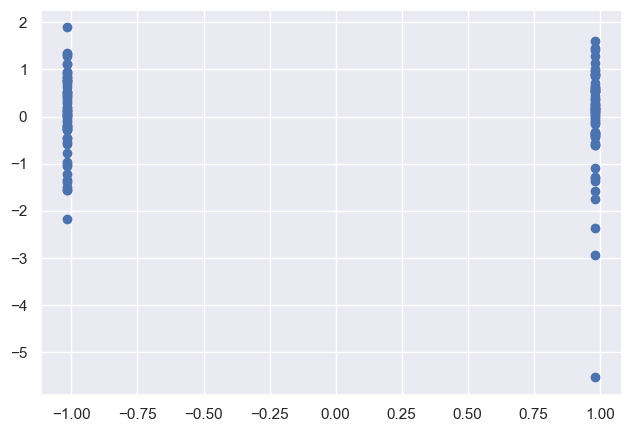

In [1141]:
plt.scatter(scaled_df[15645], scaled_df[99])

In [1142]:
pvals = np.zeros(15644)
rvals = np.zeros(15644)

for i in np.arange(15644):
    slope, intercept, r_value, p_value, std_err = linregress(scaled_df[i], scaled_df[15645])
    pvals[i] = p_value
    rvals[i] = r_value

In [1143]:
pvals1 = np.zeros(15645)
rvals1 = np.zeros(15645)

for i in np.arange(15645):
    slope, intercept, r_value, p_value, std_err = linregress(scaled_df[i], scaled_df[15646])
    pvals1[i] = p_value
    rvals1[i] = r_value

In [1144]:
pvals2 = np.zeros(15644)
rvals2 = np.zeros(15644)

for i in np.arange(15644):
    slope, intercept, r_value, p_value, std_err = linregress(scaled_df[i], scaled_df[15646])
    pvals2[i] = p_value
    rvals2[i] = r_value

In [1145]:
nums = np.arange(15645)
nums2 = np.arange(15644)

print(nums[pvals1<0.05])
print(rvals1[pvals1<0.05])

sig_genes = pd.DataFrame(nums[pvals1<0.05], rvals1[pvals1<0.05]).reset_index()
sig_genes.sort_values(by='index')

[   47    56    65 ... 15599 15620 15622]
[-0.20315637 -0.26105827 -0.18087817 ...  0.19075025  0.27797515
 -0.25589636]


,index,0
1192,-0.360703,13216
580,-0.349856,6390
1347,-0.346066,14860
191,-0.345854,2008
1155,-0.343676,12770
...,...,...
131,0.327625,1439
255,0.330347,2847
750,0.343344,8137
1300,0.344985,14343


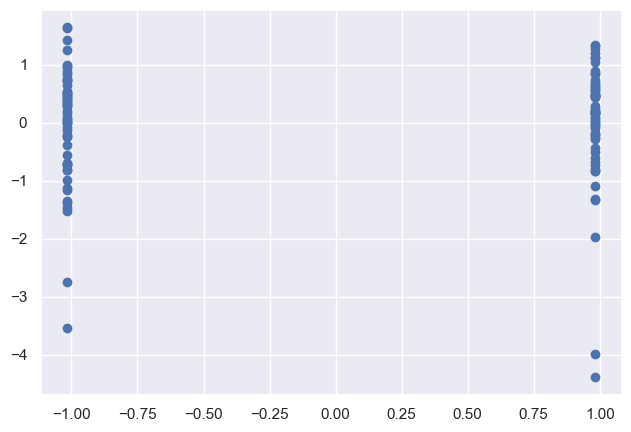

In [1146]:
plt.scatter(scaled_df[15645], scaled_df[13215])

In [1147]:
sig_df = scaled_df[nums2[pvals<0.001]]

In [1148]:
pca = PCA(n_components=2)
pca.fit(sig_df)
df_pca = pca.transform(sig_df)

<Axes: >

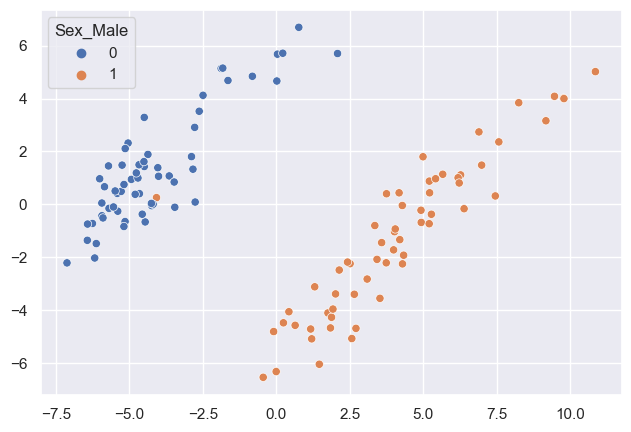

In [1149]:
sns.scatterplot(x=df_pca[:,0],y=df_pca[:,1], hue=df.Sex_Male)

Finally, we have found a way to see the differentiation between groups. 

## Visualizations

In [1150]:
asthma

,StudyID,Sex,asthma_age10,asthma_age7
0,07-01-001-1,Female,Yes,No
1,07-01-010-5,Female,Yes,No
2,07-01-011-4,Female,No,No
3,07-01-025-9,Female,No,No
4,07-01-028-5,Male,No,No
...,...,...,...,...
319,07-08-170-9,Male,No,No
320,07-08-173-2,Female,No,No
321,07-08-174-5,Male,No,No
322,07-08-177-8,Male,No,No


In [1151]:
yy_len = len(yesyes)
yn_len = len(yesno)
ny_len = len(noyes)
nn_len = len(nono)

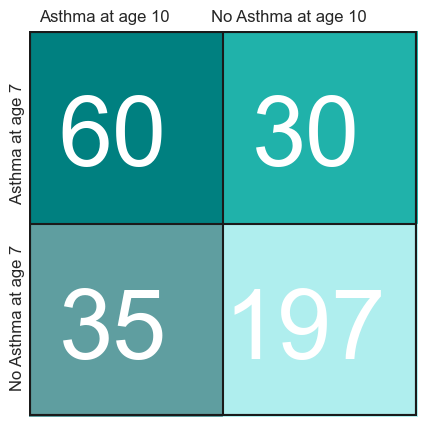

In [1152]:
fig, ax = plt.subplots(figsize=(5,5))

x1 = np.array([-1,-0.5,0])
y1 = np.array([1,1,1])

x2 = np.array([0, 0.5, 1])
y2 = np.array([-1,-1,-1])

ax.axvline(0, color='k')
ax.axvline(-1, color='k', lw=3)
ax.axvline(1, color='k', lw=3)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.axhline(0, color='k')
ax.axhline(-1, color='k', lw=3)
ax.axhline(1, color='k',lw=3)
ax.axis('off')

ax.fill_between(x1, y1, color='teal')
ax.fill_between(x1, y2, color='cadetblue')
ax.fill_between(x2, y1, color='lightseagreen')
ax.fill_between(x2, y2, color='paleturquoise')

ax.text(-1.1,-0.85, 'No Asthma at age 7         Asthma at age 7', rotation='vertical', fontsize=12)
ax.text(-0.95,1.05,'Asthma at age 10         No Asthma at age 10', fontsize=12)

ax.text(-0.85, 0.3, yy_len, color='white', fontsize=70)
ax.text(-0.85, -0.7, yn_len, color='white', fontsize=70)
ax.text(0.15, 0.3, ny_len, color='white', fontsize=70)
ax.text(0, -0.7, nn_len, color='white', fontsize=70)

plt.savefig('groups.png')

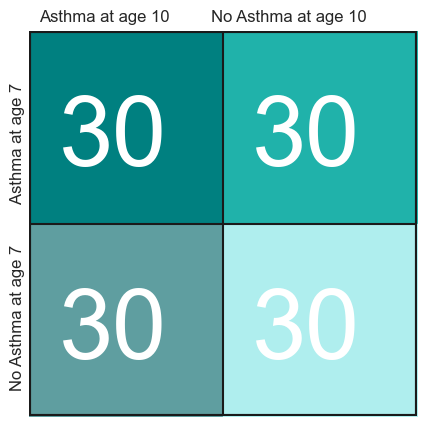

In [1153]:
fig, ax = plt.subplots(figsize=(5,5))

x1 = np.array([-1,-0.5,0])
y1 = np.array([1,1,1])

x2 = np.array([0, 0.5, 1])
y2 = np.array([-1,-1,-1])

ax.axvline(0, color='k')
ax.axvline(-1, color='k', lw=3)
ax.axvline(1, color='k', lw=3)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.axhline(0, color='k')
ax.axhline(-1, color='k', lw=3)
ax.axhline(1, color='k',lw=3)
ax.axis('off')

ax.fill_between(x1, y1, color='teal')
ax.fill_between(x1, y2, color='cadetblue')
ax.fill_between(x2, y1, color='lightseagreen')
ax.fill_between(x2, y2, color='paleturquoise')

ax.text(-1.1,-0.85, 'No Asthma at age 7         Asthma at age 7', rotation='vertical', fontsize=12)
ax.text(-0.95,1.05,'Asthma at age 10         No Asthma at age 10', fontsize=12)

ax.text(-0.85, 0.3, '30', color='white', fontsize=70)
ax.text(-0.85, -0.7, '30', color='white', fontsize=70)
ax.text(0.15, 0.3, '30', color='white', fontsize=70)
ax.text(0.15, -0.7, '30', color='white', fontsize=70)

plt.savefig('groups2.png')

## Dimensionality Reduction Asthma

In [1154]:
from sklearn.manifold import TSNE

In [1155]:
# Top asthma-differentiated genes determined by Monica
monica_genes = pd.read_csv('significant_genes_asthma.csv')
monica_genes

,Chr,start,end,pid,gid,strand,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
0,chr6,87152833,87152834,ZNF292,ZNF292,1,6.871509,6.802685,6.397606,5.838545,...,5.915107,6.759187,6.415295,6.728879,6.490296,6.603444,6.293880,6.066749,6.585557,6.235667
1,chr2,218270392,218270393,PNKD,PNKD,1,6.730958,6.826414,7.101500,7.600990,...,7.653623,7.155323,7.599389,7.327976,6.555760,6.803481,7.114189,7.112490,7.100885,7.238213
2,chr17,61942605,61942606,MED13,MED13,-1,6.761938,5.865879,5.894084,5.357309,...,4.636476,6.180685,5.334534,5.469492,5.838219,5.589258,5.425764,5.335162,5.116652,5.574824
3,chr9,112217716,112217717,PTBP3,PTBP3,-1,7.241724,7.149754,7.590507,7.221086,...,7.055428,7.268831,7.310287,7.446232,7.578251,7.266260,7.280597,7.424597,7.219205,7.059675
4,chr10,70247329,70247330,NPFFR1,NPFFR1,-1,0.205158,-0.111401,2.577938,-2.264743,...,1.491426,2.591850,0.290140,1.342636,0.283630,1.693727,0.524226,1.674432,-2.576835,-1.908991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,chr9,12775021,12775022,LURAP1L,LURAP1L,1,4.655191,4.361087,4.473240,3.885004,...,3.518906,1.885581,3.460065,3.185910,4.076188,2.891667,3.236944,3.259394,4.052522,3.135403
557,chr7,107563484,107563485,DUS4L,DUS4L,1,4.516744,4.136527,3.956449,4.503441,...,3.518906,4.580168,4.034301,4.353205,3.816125,4.501082,4.199791,4.481787,3.930960,4.660864
558,chr7,25134697,25134698,C7orf31,C7orf31,-1,3.280446,1.267111,-2.065918,-2.264743,...,1.250417,2.029971,1.668652,1.503101,0.935707,1.693727,2.212282,2.341856,0.882597,1.260934
559,chr15,90868592,90868593,FURIN,FURIN,1,7.362144,7.404299,7.977109,7.176126,...,7.537500,6.577233,6.294642,6.964257,7.936731,7.273376,7.140571,7.151118,7.684085,7.258427


In [1156]:
monica_genes = sampled_genes[sampled_genes['pid'].isin(monica_genes['pid'])].drop(columns=cols).T

In [1157]:
# euclidian distance code from Monica

array = np.array(monica_genes)
distances_mat = np.empty((monica_genes.shape[0], monica_genes.shape[0]))
for idx, row in enumerate(array):
    dist = np.apply_along_axis(lambda x: np.linalg.norm(x - row), 1, array)
    distances_mat[idx, :] = dist

names = monica_genes.index
distances_df = pd.DataFrame(distances_mat)
distances_df.index = names
distances_df.columns = names
distances_df

,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,07-08-015-6,07-08-017-3,07-08-026-9,07-08-128-3,07-08-117-4,07-01-100-6,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
07-08-095-0,0.000000,30.364060,31.367010,32.730706,32.015080,30.553371,24.877707,27.945088,30.465476,28.665860,...,30.643132,31.463315,31.153386,23.824924,26.707599,23.357179,25.334772,24.750146,27.192550,26.530041
07-08-120-8,30.364060,0.000000,27.783434,35.353542,35.119640,33.204047,29.772812,32.691353,38.154985,33.933930,...,33.410548,34.833137,36.715198,33.040076,28.029098,31.793114,32.915029,31.263947,30.156085,31.520459
07-08-122-0,31.367010,27.783434,0.000000,36.561028,33.081194,34.106803,31.072870,32.595188,38.702907,33.369665,...,33.479097,35.514245,39.805593,33.456617,25.912462,29.905481,34.556847,31.703929,29.434456,32.149921
07-08-123-1,32.730706,35.353542,36.561028,0.000000,29.579638,24.517369,26.525830,25.805034,26.198693,31.799581,...,28.579458,39.143443,30.398760,32.968658,38.713368,32.275839,32.090531,31.206628,30.107861,30.954519
07-08-015-6,32.015080,35.119640,33.081194,29.579638,0.000000,28.152701,29.296694,25.337646,31.624977,27.539223,...,26.344895,38.342346,32.726771,31.770500,34.514359,30.909062,30.937187,31.855600,28.912334,30.770557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07-08-160-0,23.357179,31.793114,29.905481,32.275839,30.909062,31.568110,25.053399,25.126487,27.905187,27.676294,...,29.798544,27.729347,29.680201,23.391983,27.404198,0.000000,24.396759,21.740395,27.455826,21.825868
07-08-163-7,25.334772,32.915029,34.556847,32.090531,30.937187,31.563576,26.845025,28.396001,28.366493,28.118432,...,30.223170,31.787088,27.916121,20.991145,30.813063,24.396759,0.000000,22.190806,29.726511,25.173590
07-08-085-2,24.750146,31.263947,31.703929,31.206628,31.855600,30.807195,23.782572,27.195435,25.564999,27.781477,...,29.666604,30.267060,25.784105,23.135069,27.600619,21.740395,22.190806,0.000000,27.191236,24.323616
07-08-082-3,27.192550,30.156085,29.434456,30.107861,28.912334,27.179007,26.471500,27.568184,33.910834,30.005109,...,30.316215,34.618517,33.694152,30.231264,29.237482,27.455826,29.726511,27.191236,0.000000,29.842392


In [1158]:
# Code adapted from Monica Gould
# determine nearest neighbors in original dataset

top_dists = np.empty([120, 10])
top_neighbors = np.empty([120,10], dtype='<U11')

for i in np.arange(len(monica_genes)):
    top = distances_df.iloc[i].sort_values()[1:11]
    top_dists[i] = top.values
    top_neighbors[i] = top.index

In [1159]:
# create dataframe with data of ids and nearest neighbors

ids = pd.DataFrame(monica_genes.index, columns=['ID'])
top_asthma_neighbors_df = ids.join(pd.DataFrame(top_neighbors))
top_asthma_neighbors_df.head()

,ID,0,1,2,3,4,5,6,7,8,9
0,07-08-095-0,07-01-040-9,07-08-160-0,07-08-034-6,07-08-021-1,07-08-060-4,07-02-022-1,07-02-027-8,07-01-074-3,07-07-029-9,07-08-081-0
1,07-08-120-8,07-08-081-0,07-08-096-6,07-08-122-0,07-08-151-8,07-08-021-1,07-01-166-9,07-08-142-7,07-02-057-4,07-02-022-1,07-08-034-6
2,07-08-122-0,07-08-151-8,07-08-081-0,07-08-120-8,07-02-057-4,07-08-034-6,07-08-142-7,07-07-016-4,07-08-082-3,07-08-156-0,07-08-096-6
3,07-08-123-1,07-08-017-3,07-02-034-8,07-02-046-3,07-01-013-3,07-02-134-9,07-02-118-5,07-07-020-6,07-08-128-3,07-08-068-9,07-02-038-2
4,07-08-015-6,07-08-128-3,07-07-019-3,07-02-046-3,07-02-134-9,07-02-141-7,07-07-064-2,07-08-049-0,07-02-019-1,07-07-029-9,07-08-051-7


In [1160]:
monica_df = monica_genes.reset_index(drop=True).join(df['asthma_group'])
monica_df

,55,85,128,130,240,249,295,300,307,308,...,15415,15421,15465,15474,15477,15543,15619,15621,15633,asthma_group
0,1.921365,7.018023,4.673927,6.757553,4.363587,7.677414,2.351999,-2.602197,1.485266,-2.602197,...,5.077283,7.556413,4.897649,7.365029,1.485266,6.201934,0.857235,7.924302,3.280446,1
1,3.589039,7.119340,3.589039,6.739099,4.437036,7.568079,-2.433329,-2.433329,4.621954,-2.433329,...,4.915399,7.469046,4.308138,7.240863,-2.433329,6.242628,-2.433329,8.216825,5.314864,1
2,2.792063,6.397606,3.360346,6.738213,4.702266,6.788950,-2.065918,-2.065918,3.864819,-2.065918,...,4.702266,7.866296,4.922766,6.891184,-2.065918,6.260511,-2.065918,8.359298,3.864819,1
3,1.194688,6.293678,4.529673,6.932474,4.421757,7.146768,-2.264743,0.057185,1.435697,0.542612,...,5.219073,7.359138,5.136136,6.552240,1.194688,6.552240,2.490144,7.643649,4.746484,1
4,1.339069,6.399274,4.566138,6.044545,4.254677,7.006342,-2.120362,-0.535400,1.580077,-2.120362,...,4.479551,7.632854,4.934920,6.064513,0.201566,5.192521,-2.120362,6.795517,3.237190,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1.854192,7.051279,4.426443,6.194979,4.745816,7.079970,-2.393736,-2.393736,3.714789,-0.071807,...,5.271600,7.092094,5.354457,6.528105,0.413619,5.470451,0.413619,7.529592,3.387624,2
116,1.054741,6.551518,4.514172,7.003557,3.797245,7.622258,-2.645699,0.161656,2.639703,-2.645699,...,4.611689,6.599854,5.302668,6.823943,2.398695,5.897333,-2.645699,7.656940,2.969011,2
117,2.341856,6.650364,4.598196,6.677081,4.186882,7.002711,-0.828069,-0.091103,1.979286,2.110531,...,5.054574,7.199837,5.149211,6.879290,2.341856,5.614875,-2.413031,7.785414,3.962008,2
118,2.915019,6.774105,4.052522,6.663957,4.109666,6.904965,0.230520,-2.576835,2.552449,-2.576835,...,4.841018,8.005307,5.236947,6.809028,-2.576835,6.207800,-2.576835,8.305044,3.726946,2


In [1161]:
sns.set_theme(rc={'figure.figsize':(7.5,5)})
sns.set_style('darkgrid')

<Axes: >

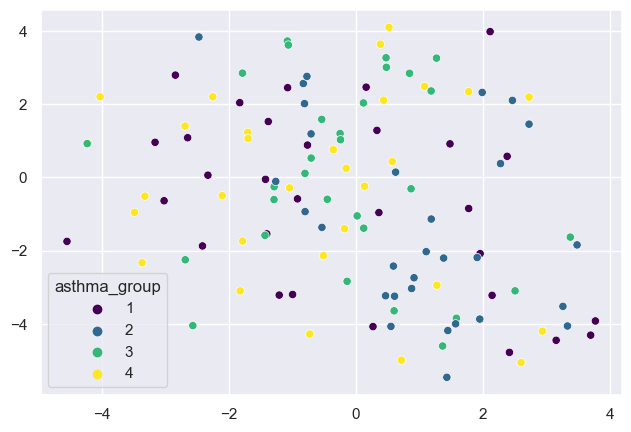

In [1162]:
# perform tSNE
monica_df.columns = monica_df.columns.astype(str)

tsne = TSNE(n_components=2)
asthma_tsne = tsne.fit_transform(monica_df)

sns.scatterplot(x=asthma_tsne[:,0], y=asthma_tsne[:,1], hue=monica_df['asthma_group'], palette='viridis')

In [1163]:
# determine nearest neighbors for tSNE embedding
tsne_nn = pd.DataFrame(monica_genes.index, columns=['ID'])
tsne_nn

tsne_nn['x_coord'] = asthma_tsne[:,0]
tsne_nn['y_coord'] = asthma_tsne[:,1]

tsne_nn = tsne_nn.set_index('ID')

array = np.array(tsne_nn)
distances_mat = np.empty((tsne_nn.shape[0], tsne_nn.shape[0]))
for idx, row in enumerate(array):
    dist = np.apply_along_axis(lambda x: np.linalg.norm(x - row), 1, array)
    distances_mat[idx, :] = dist

names = tsne_nn.index
distances_df = pd.DataFrame(distances_mat)
distances_df.index = names
distances_df.columns = names
distances_df.head()

ID,07-08-095-0,07-08-120-8,07-08-122-0,07-08-123-1,07-08-015-6,07-08-017-3,07-08-026-9,07-08-128-3,07-08-117-4,07-01-100-6,...,07-02-141-7,07-02-139-6,07-02-147-2,07-08-060-4,07-08-151-8,07-08-160-0,07-08-163-7,07-08-085-2,07-08-082-3,07-08-103-8
ID,,,,,,,,,,,,,,,,,,,,,
07-08-095-0,0.000000,1.895624,1.771346,7.198539,6.857134,4.757871,3.925879,3.802358,6.592961,2.399009,...,5.331359,2.348711,6.651140,1.536725,1.452838,0.967121,1.678249,1.281296,1.920205,1.187985
07-08-120-8,1.895624,0.000000,0.394928,8.435800,8.637955,6.582774,5.803164,5.056350,8.416882,3.955899,...,6.526460,2.541254,8.359949,3.267349,0.442817,2.150077,3.405303,3.094678,2.473015,2.253885
07-08-122-0,1.771346,0.394928,0.000000,8.070205,8.603234,6.520137,5.696456,4.704470,8.179343,3.661942,...,6.161448,2.800784,8.076635,3.235329,0.460984,2.203656,3.376371,3.027537,2.095879,2.339702
07-08-123-1,7.198539,8.435800,8.070205,0.000000,8.787758,7.400158,6.547033,3.414099,4.395000,4.839799,...,1.909357,9.460930,3.133808,7.377264,8.127444,7.994700,7.396005,7.120426,5.981037,8.187251
07-08-015-6,6.857134,8.637955,8.603234,8.787758,0.000000,2.137942,3.154283,7.313143,4.663878,6.391690,...,8.003906,7.040979,5.880681,5.373092,8.215900,6.522706,5.233832,5.579755,8.036635,6.474538


In [1164]:
# determine nearest neighbors for tSNE data

top_dists = np.empty([120, 10])
top_neighbors = np.empty([120,10], dtype='<U11')

for i in np.arange(len(monica_genes)):
    top = distances_df.iloc[i].sort_values()[1:11]
    top_dists[i] = top.values
    top_neighbors[i] = top.index
    
    
ids = pd.DataFrame(monica_genes.index, columns=['ID'])
top_asthma_neighbors_tsne = ids.join(pd.DataFrame(top_neighbors))
top_asthma_neighbors_tsne.head()

,ID,0,1,2,3,4,5,6,7,8,9
0,07-08-095-0,07-08-034-6,07-01-044-5,07-02-022-1,07-08-021-1,07-08-160-0,07-01-166-9,07-08-142-7,07-02-057-4,07-08-103-8,07-08-081-0
1,07-08-120-8,07-08-122-0,07-08-151-8,07-08-096-6,07-08-081-0,07-02-057-4,07-02-093-4,07-08-125-4,07-08-034-6,07-01-044-5,07-08-095-0
2,07-08-122-0,07-08-120-8,07-08-151-8,07-02-057-4,07-08-096-6,07-08-081-0,07-08-034-6,07-08-125-4,07-02-093-4,07-08-095-0,07-01-044-5
3,07-08-123-1,07-08-028-2,07-01-139-3,07-07-019-3,07-08-091-3,07-07-010-1,07-01-141-2,07-07-020-6,07-02-109-0,07-08-049-0,07-02-106-1
4,07-08-015-6,07-08-007-1,07-02-076-7,07-07-093-1,07-08-144-3,07-08-051-7,07-08-017-3,07-01-010-5,07-08-010-2,07-02-067-2,07-08-106-4


In [1165]:
# determine how well nearest neighbors were preserved after tSNE transformation
ratios = np.empty(120)

for i in np.arange(len(monica_genes)):
    shared = [x for x in top_asthma_neighbors_tsne.iloc[i].values[1:] \
              if x in top_asthma_neighbors_df.iloc[i].values[1:]]
    ratio = len(shared)/10
    ratios[i] = ratio

ratios

array([0.5, 0.6, 0.6, 0.1, 0.1, 0.3, 0.3, 0.1, 0.2, 0.2, 0.1, 0.4, 0.4,
       0.3, 0.1, 0.1, 0.6, 0.2, 0.5, 0.3, 0.3, 0.4, 0.5, 0.2, 0.7, 0.4,
       0.2, 0.7, 0.5, 0.5, 0.6, 0.4, 0.6, 0.4, 0.3, 0. , 0.2, 0.5, 0.3,
       0.4, 0.5, 0.6, 0.3, 0.5, 0.1, 0.7, 0.5, 0.3, 0.2, 0.7, 0.4, 0.3,
       0.3, 0.5, 0.2, 0.4, 0.3, 0.4, 0.2, 0.3, 0.5, 0.3, 0.5, 0.6, 0.4,
       0.3, 0.3, 0.3, 0.5, 0.5, 0.5, 0.4, 0.5, 0.7, 0.5, 0.4, 0.7, 0.6,
       0.4, 0.2, 0.7, 0.6, 0.2, 0.7, 0.3, 0.5, 0.3, 0.2, 0.3, 0. , 0.5,
       0.5, 0.5, 0.1, 0.3, 0.6, 0.4, 0.1, 0.5, 0.4, 0.4, 0.5, 0.5, 0.4,
       0.6, 0.3, 0.4, 0.5, 0.4, 0.4, 0.5, 0.6, 0.4, 0.6, 0.7, 0.6, 0.5,
       0.5, 0.3, 0.3])

0.4
0.1707825127659933


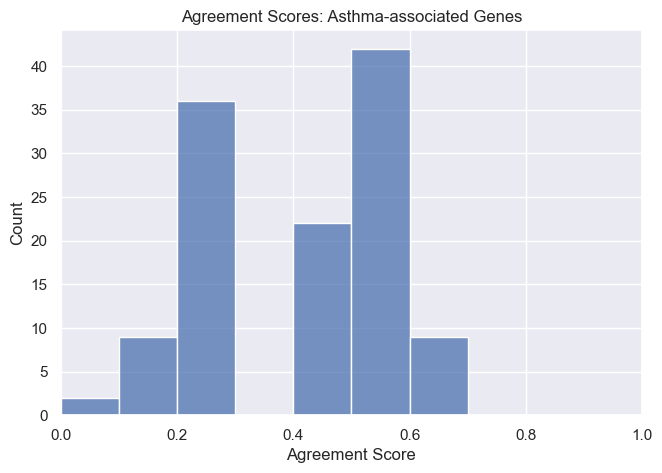

In [1166]:
sns.histplot(ratios, binwidth=0.1)
plt.xlabel('Agreement Score')
plt.title('Agreement Scores: Asthma-associated Genes')
plt.xlim(0,1)

print(np.mean(ratios))
print(np.std(ratios))

plt.savefig('Agreement_Asthma.png')

## Dimensionality Reduction Sex

In [1167]:
# Top sex-differentiated genes from Roger
roger_genes = pd.read_csv('gene.csv').drop(columns=['Unnamed: 0'])
roger_genes

,15638,15635,15642,15634,15643,15636,15641,15639,15637,15640,...,12637,1420,10261,1889,13394,3203,2989,8140,2236,4785
0,6.721984,6.433977,5.802945,6.585155,4.316666,5.425709,3.664590,2.152691,4.929185,4.139270,...,5.869478,3.664590,4.929185,6.555150,5.542461,7.672764,-0.280269,4.409030,1.921365,6.614549
1,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,-2.433329,...,5.659428,2.776125,5.128914,6.390038,4.105830,8.027127,-2.433329,4.726543,1.654134,6.005463
2,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,-2.065918,...,2.688969,4.876596,5.917075,5.810599,4.702266,7.717080,-0.480956,5.093953,3.219484,6.372874
3,-0.679781,-2.264743,-0.679781,-0.679781,-2.264743,-0.679781,-2.264743,-2.264743,-2.264743,-2.264743,...,4.934929,3.516617,5.327714,6.308904,5.879915,7.673366,-2.264743,5.083985,0.542612,6.486801
4,7.125190,6.187977,5.347243,7.086652,4.146424,5.862631,3.305902,3.660997,3.371491,3.607558,...,6.197050,1.339069,5.314266,6.548523,4.449493,7.539634,-0.535400,4.977670,0.686993,6.644509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-2.393736,-2.393736,-2.393736,-0.071807,-2.393736,-2.393736,-2.393736,-2.393736,-2.393736,-2.393736,...,4.766136,-0.808773,5.730386,6.783684,5.458013,7.673699,0.413619,4.320510,0.413619,5.677727
116,6.585522,6.001760,4.838117,7.247603,4.514172,6.023186,4.648922,2.846154,4.095768,3.082222,...,5.348655,0.161656,5.635072,6.551518,4.122485,7.677356,-2.645699,4.199791,-0.323771,6.390475
117,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,-2.413031,...,5.133863,1.979286,5.294328,6.692877,5.535336,7.427747,2.944521,4.381385,1.287408,6.168169
118,-0.991872,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,-2.576835,...,6.048874,4.365680,6.099123,6.644753,6.475734,7.903956,-2.576835,4.622838,2.067022,5.894841


In [1168]:
roger_df = df[roger_genes.columns].copy()
roger_df['Sex'] = df['Sex_Male']
roger_df

,15638,15635,15642,15634,15643,15636,15641,15639,15637,15640,...,1420,10261,1889,13394,3203,2989,8140,2236,4785,Sex
0,6.862233,5.961955,5.951500,7.185834,5.124337,5.582922,5.196941,4.387371,4.188063,3.730856,...,4.356007,5.008084,6.613084,4.813997,7.176887,-2.151787,4.616397,1.018138,6.128983,1
1,-0.284674,-1.869637,-0.284674,-1.869637,-1.869637,-1.869637,-1.869637,-1.869637,-1.869637,-1.869637,...,1.300288,5.207179,6.733989,3.259646,7.297781,2.217826,4.470213,0.937718,5.290234,0
2,6.963074,5.995939,6.159592,6.976310,5.067772,4.911181,4.649983,3.725085,3.956410,3.231270,...,2.371448,5.564928,6.758667,3.397920,7.509862,0.786485,4.671843,1.864488,6.306558,1
3,7.086690,5.935989,4.392103,6.293922,3.752985,4.508748,4.480459,3.248512,4.451604,2.776444,...,2.776444,5.543346,6.484025,5.782249,7.868007,-2.177753,4.833474,1.909710,6.244312,1
4,6.966609,6.194292,4.492920,6.628769,5.015955,4.910985,4.540617,3.024367,3.620470,3.430992,...,1.057534,5.305461,7.043117,4.563887,7.320910,1.298542,4.041046,2.121664,5.603727,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.666704,-1.655224,-1.655224,-1.655224,-1.655224,-1.655224,-1.655224,-1.655224,-1.655224,-0.070261,...,-1.655224,5.779405,6.245643,4.453301,8.179247,2.045216,4.883935,2.045216,6.281414,0
116,6.947807,5.823818,5.010904,6.885373,5.356039,5.249911,4.692221,3.642752,3.501890,2.608805,...,3.170684,5.529371,6.604505,6.319776,7.224916,-1.783512,4.238856,-1.783512,6.117355,1
117,7.519253,6.215703,5.486831,6.782287,4.956316,4.926873,4.476707,2.719277,2.027399,3.081847,...,3.536413,4.593746,6.263598,4.209603,7.484307,-0.088078,3.753225,1.786391,5.826806,1
118,7.093253,6.309664,4.664220,6.864703,4.741526,4.994068,3.181438,3.322301,2.288354,3.623957,...,0.703391,5.363642,6.613713,3.677396,7.385884,-0.519001,4.861820,1.355468,6.529031,1


In [1169]:
tsne = TSNE(n_components=2)
sex_tsne = tsne.fit_transform(roger_df)

<Axes: >

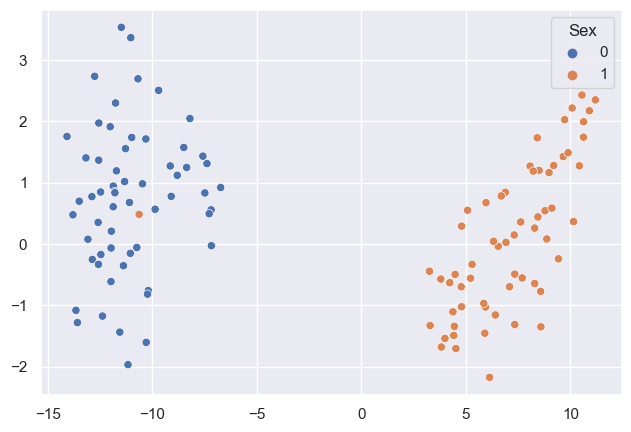

In [1170]:
sns.scatterplot(x=sex_tsne[:,0], y=sex_tsne[:,1], hue=roger_df['Sex'])

In [1172]:
array = np.array(roger_genes)
distances_mat = np.empty((roger_genes.shape[0], roger_genes.shape[0]))
for idx, row in enumerate(array):
    dist = np.apply_along_axis(lambda x: np.linalg.norm(x - row), 1, array)
    distances_mat[idx, :] = dist

names = roger_genes.index
distances_df = pd.DataFrame(distances_mat)
distances_df.index = names
distances_df.columns = names
distances_df

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.000000,39.002703,44.835147,41.496128,47.938092,42.107116,33.284535,36.462472,30.963993,37.705960,...,50.953288,28.271060,32.389765,28.329694,37.551429,34.594864,22.803263,34.765494,40.378199,25.928598
1,39.002703,0.000000,36.402803,37.957174,53.355756,35.790632,27.806731,45.404502,41.064275,31.128376,...,55.400255,40.650728,31.451469,40.150126,28.502171,26.509366,38.609125,32.389261,30.794188,35.252234
2,44.835147,36.402803,0.000000,35.925532,41.168160,28.436782,36.079570,39.663475,40.056589,37.505619,...,42.740273,47.046821,37.618710,42.738318,34.634896,35.561368,42.072048,40.102343,31.238682,40.012606
3,41.496128,37.957174,35.925532,0.000000,42.400499,28.289471,32.116124,36.781208,34.453998,35.796525,...,47.627866,44.236793,34.730904,38.630779,35.658294,36.311138,39.658022,36.517252,31.140761,39.129225
4,47.938092,53.355756,41.168160,42.400499,0.000000,36.747066,47.799651,27.546700,33.380930,51.166035,...,24.580865,50.412952,50.324624,41.656566,50.587626,51.530689,43.181199,55.759208,47.630672,41.474782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,34.594864,26.509366,35.561368,36.311138,51.530689,33.953882,22.736467,41.745516,38.611503,26.729089,...,53.761003,35.664426,24.424226,34.266320,23.787179,0.000000,32.232206,22.288139,26.081236,29.561683
116,22.803263,38.609125,42.072048,39.658022,43.181199,40.604277,31.686863,34.223586,28.176194,34.698564,...,47.178627,26.923773,32.273093,25.835889,36.533466,32.232206,0.000000,34.815805,37.816370,23.315401
117,34.765494,32.389261,40.102343,36.517252,55.759208,38.065445,24.269351,46.104364,41.057156,28.103438,...,58.138501,34.443099,23.197560,35.167289,27.938408,22.288139,34.815805,0.000000,28.606991,34.316487
118,40.378199,30.794188,31.238682,31.140761,47.630672,28.757710,26.213160,40.662418,38.454374,30.716461,...,49.948939,39.140030,30.233233,37.388046,27.185099,26.081236,37.816370,28.606991,0.000000,33.208472


In [1173]:
# determine nearest neighbors for sex data

top_dists = np.empty([120, 10])
top_neighbors = np.empty([120,10])

for i in np.arange(len(roger_genes)):
    top = distances_df.iloc[i].sort_values()[1:11]
    top_dists[i] = top.values
    top_neighbors[i] = top.index
    
    
ids = pd.DataFrame(roger_genes.index, columns=['ID'])
top_sex_neighbors_df = ids.join(pd.DataFrame(top_neighbors))
top_sex_neighbors_df.head()

,ID,0,1,2,3,4,5,6,7,8,9
0,0,107.0,116.0,90.0,69.0,84.0,74.0,42.0,50.0,39.0,77.0
1,1,54.0,115.0,21.0,92.0,6.0,59.0,114.0,79.0,73.0,12.0
2,2,93.0,63.0,5.0,118.0,64.0,92.0,23.0,49.0,16.0,103.0
3,3,49.0,63.0,5.0,93.0,46.0,103.0,53.0,66.0,118.0,21.0
4,4,110.0,57.0,76.0,41.0,78.0,32.0,7.0,102.0,89.0,85.0


In [1174]:
# determine nearest neighbors for tSNE embedding for sex
tsne_nn = pd.DataFrame(roger_genes.index, columns=['ID'])
tsne_nn

tsne_nn['x_coord'] = sex_tsne[:,0]
tsne_nn['y_coord'] = sex_tsne[:,1]

tsne_nn = tsne_nn.set_index('ID')

array = np.array(tsne_nn)
distances_mat = np.empty((tsne_nn.shape[0], tsne_nn.shape[0]))
for idx, row in enumerate(array):
    dist = np.apply_along_axis(lambda x: np.linalg.norm(x - row), 1, array)
    distances_mat[idx, :] = dist

names = tsne_nn.index
distances_df = pd.DataFrame(distances_mat)
distances_df.index = names
distances_df.columns = names
distances_df.head()

ID,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
ID,,,,,,,,,,,,,,,,,,,,,
0,0.000000,18.686386,2.188309,2.942344,2.055459,17.125448,4.699542,19.404579,2.029902,2.757024,...,19.013725,0.585470,0.819841,3.462252,17.818417,16.714508,1.694925,3.157419,1.288930,3.230946
1,18.686386,0.000000,20.869019,20.107254,18.939957,1.990065,22.463533,1.436958,16.678646,20.975641,...,2.312782,18.241850,19.288765,21.015884,2.351976,3.914716,17.002649,21.562437,19.036823,15.461947
2,2.188309,20.869019,0.000000,2.670758,2.776742,19.313707,3.207174,21.592777,4.216085,1.460783,...,21.200010,2.685824,1.637114,2.544374,20.004864,18.889915,3.866765,1.392715,2.164229,5.407569
3,2.942344,20.107254,2.670758,0.000000,1.261729,18.727474,2.357497,20.978611,4.391276,1.431113,...,20.722029,3.481786,2.199783,0.911771,19.532158,18.596027,3.837977,2.031598,1.695867,5.111002
4,2.055459,18.939957,2.776742,1.261729,0.000000,17.527401,3.570956,19.785595,3.174307,2.126546,...,19.508196,2.497799,1.552771,2.117250,18.316441,17.358698,2.610819,2.766235,0.816521,3.849284


In [1175]:
# top neighbors for sex genes
top_dists = np.empty([120, 10])
top_neighbors = np.empty([120,10])

for i in np.arange(len(roger_genes)):
    top = distances_df.iloc[i].sort_values()[1:11]
    top_dists[i] = top.values
    top_neighbors[i] = top.index
    
    
ids = pd.DataFrame(roger_genes.index, columns=['ID'])
top_sex_neighbors_tsne = ids.join(pd.DataFrame(top_neighbors))
top_sex_neighbors_tsne.head()

,ID,0,1,2,3,4,5,6,7,8,9
0,0,34.0,47.0,111.0,112.0,16.0,76.0,12.0,10.0,58.0,118.0
1,1,61.0,53.0,57.0,30.0,68.0,69.0,79.0,74.0,109.0,106.0
2,2,105.0,104.0,92.0,16.0,117.0,9.0,10.0,112.0,40.0,70.0
3,3,71.0,67.0,81.0,70.0,113.0,31.0,46.0,40.0,88.0,100.0
4,4,21.0,41.0,118.0,31.0,22.0,12.0,58.0,3.0,71.0,10.0


In [1176]:
# determine how well nearest neighbors were preserved after tSNE transformation
ratios = np.empty(120)

for i in np.arange(len(roger_genes)):
    shared = [x for x in top_sex_neighbors_tsne.iloc[i].values[1:] \
              if x in top_sex_neighbors_df.iloc[i].values[1:]]
    ratio = len(shared)/10
    ratios[i] = ratio

ratios

array([0. , 0.1, 0.2, 0.1, 0.1, 0.1, 0. , 0.1, 0.3, 0. , 0. , 0. , 0.2,
       0. , 0.2, 0.1, 0.1, 0. , 0. , 0. , 0.2, 0.2, 0.1, 0.1, 0.1, 0. ,
       0.1, 0.1, 0.2, 0. , 0. , 0.2, 0.1, 0. , 0.1, 0.4, 0.3, 0.2, 0. ,
       0.2, 0.1, 0.1, 0. , 0.1, 0.3, 0.1, 0.1, 0.1, 0.1, 0.2, 0. , 0.1,
       0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0. , 0.1, 0. , 0.1, 0. ,
       0. , 0.1, 0. , 0. , 0.1, 0. , 0.2, 0.2, 0. , 0.1, 0.3, 0. , 0. ,
       0.1, 0.1, 0.1, 0. , 0. , 0. , 0.2, 0. , 0.1, 0.1, 0.1, 0. , 0. ,
       0. , 0.1, 0.1, 0.3, 0. , 0.1, 0. , 0.2, 0. , 0.1, 0. , 0.2, 0.1,
       0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0. , 0. ,
       0. , 0.2, 0.2])

0.0875
0.0861805275763228


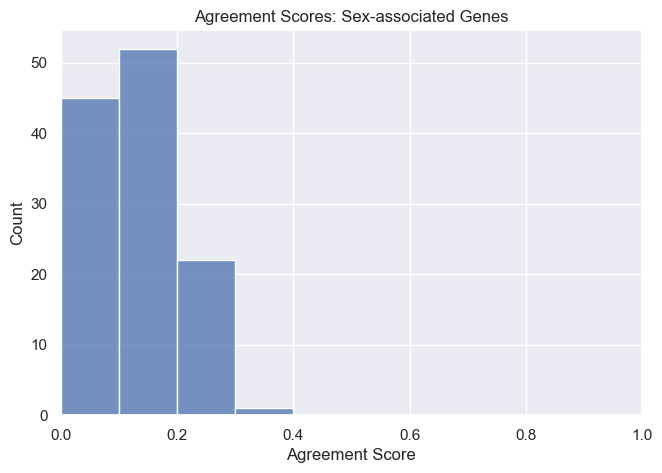

In [1181]:
sns.histplot(ratios,binwidth=0.1)
plt.xlim(0,1)
plt.xlabel('Agreement Score')
plt.title('Agreement Scores: Sex-associated Genes')

print(np.mean(ratios))
print(np.std(ratios))

plt.savefig('Agreement_Sex.png')